In [68]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

## Equipe
### Ícaro de Lima - 385194 <br> Thalisson Felipe - 390195

# 1. Importar e separar o conjunto de dados fornecido em treinamento e teste

In [69]:
df = pd.read_csv('noticias.csv')
df.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [70]:
X, y = df['title'] +  ' ' + df['text'], df['label'].replace(['FAKE', 'REAL'], [0, 1]).values

# 2. Criar uma matriz vetorizada que represente os textos utilizando o CountVectorizer

In [71]:
count_vectorizer = CountVectorizer()
count_matrix = count_vectorizer.fit_transform(X)
count_vectorizer_X = count_matrix.toarray()

# 3. Criar uma matriz vetorizada que represente os textos utilizando o TfidfVectorizer

In [73]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(X)
tfidf_vectorizer_X = tfidf_matrix.toarray()

# 4. Criar dois modelos para classificar os textos utilizando o algoritmo Naive Bayes (multinomial) utilizando o CountVectorizer e o TfidfVectorizer

In [74]:
def naive_bayes(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=0)
    mnb = MultinomialNB()
    mnb.fit(X_train, y_train)

    return mnb, X_test, y_test

def show_metrics(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print('Acurácia: ', accuracy_score(y_pred, y_test))
    ax= plt.subplot()
    sns.heatmap(confusion_matrix(y_pred, y_test), annot=True, ax=ax, fmt='g')
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
    ax.yaxis.set_ticklabels(['REAL', 'FAKE'])
    plt.show()

In [75]:
count_model, count_X_test, count_y_test = naive_bayes(count_vectorizer_X, y)

In [76]:
tfidf_model, tfudf_X_test, tfudf_y_test = naive_bayes(tfidf_vectorizer_X, y)

# 5. Comparar os resultados utilizando a precisão e a Matriz de Confusão

Acurácia:  0.8905551170744541


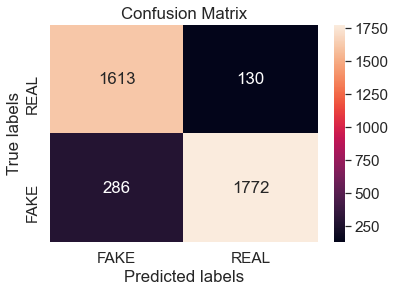

In [77]:
show_metrics(count_model, count_X_test, count_y_test)

Acurácia:  0.739542225730071


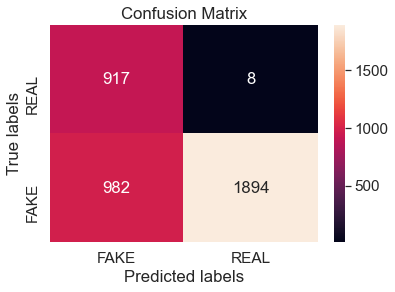

In [78]:
show_metrics(tfidf_model, tfudf_X_test, tfudf_y_test)

# 6. [BÔNUS] Propor passos adicionais para melhorar os resultados encontrados

In [79]:
count_vectorizer2 = CountVectorizer(stop_words='english')
count_matrix2 = count_vectorizer2.fit_transform(X)
count_vectorizer_X2 = count_matrix2.toarray()

In [80]:
count_model2, count_X_test2, count_y_test2 = naive_bayes(count_vectorizer_X2, y)

Melhorou um pouquinho rs

Acurácia:  0.8926598263614838


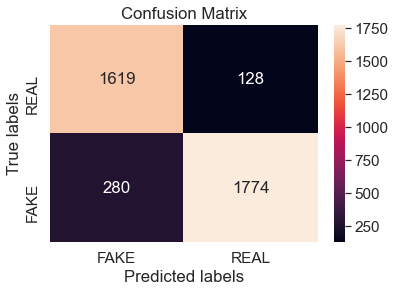

In [81]:
show_metrics(count_model2, count_X_test2, count_y_test2)